In [1]:
import os
import sys
from scipy import stats
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils

from string import ascii_lowercase as abc
abc = [*abc] + [f'{l}2' for l in abc]

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
ot1_color = 'tab:green'
palette_tcrs = {'OT1': ot1_color, 
                'OTI': ot1_color, 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue',
                'Naïve': 'tab:blue',
                'Human': 'Firebrick',
               }

palette_educated = sb.color_palette('Oranges', 16)[:8]
palette_naive_test = 'Blues'
palette_naive_ot1 = 'Greens'
palette_human = sb.color_palette('Reds', 16)[8-1:]

color_cdr3 = 'violet'

cmap_distances = 'viridis_r'

## Load data

In [6]:
def load_data_permutation_importance(epitope='VPSVWRSSL'):
    fname = f'../activation-prediction/results/{epitope}_tcr_stratified_permutation_importance_regression.csv.gz'
    pdf = pd.read_csv(fname)

    mdf =  pdf.groupby(['tcr', 'group', 'shuffle']).apply(lambda g: pd.Series({
        'mae': g['abserr'].mean(),
        'r2': metrics.r2_score(g['activation'], g['pred']),
        'pearson': g['activation'].corr(g['pred'], method='pearson'),
        'spearman': g['activation'].corr(g['pred'], method='spearman'),
    })).reset_index().drop(columns='shuffle')
    

    ddf = mdf.melt(['tcr', 'group']).merge(
        mdf[
            mdf['group'] == 'all'
        ].drop(columns='group').melt('tcr', value_name='base').drop_duplicates(),
        on=['tcr', 'variable']
    )
    ddf['diff'] = ddf['value'] - ddf['base']
    ddf['rel'] = ddf['value'] / ddf['base'] - 1  # positive = increase
    ddf['item'] = ddf['group'].str.split('_').str[0]
    ddf['is_educated'] = np.where(
        ddf['tcr'].str.startswith('ED') | ddf['tcr'].str.startswith('R'),
        'Educated', 'Naive'
    )
    permutation_data = ddf[(
        ddf['is_educated'] == "Educated"
    ) & (
        ddf['variable'] == 'spearman'
    ) & (
        ddf['group'].str.startswith('pos_')
          | ddf['group'].isin(['cdr3', 'all'])
    )].rename(columns={
        'value': 'Spearman', 'group': 'Permutation'
    })
    permutation_data = permutation_data.replace({
        'pos_0': 'P1', 'pos_1': 'P2', 'pos_2': 'P3', 'pos_3': 'P4',
        'pos_4': 'P5', 'pos_5': 'P6', 'pos_6': 'P7', 'pos_7': 'P8', 'pos_8': 'P9',
        'cdr3': 'CDR3', 'all': '-'
    })
    return permutation_data
df_importance_mice = load_data_permutation_importance('SIINFEKL')
df_importance_human = load_data_permutation_importance()

In [7]:
def load_available_visualisations(repertoire='human'):
    path_in = f'figures/3dModel/{repertoire}'
    files = os.listdir(path_in)
    files = [el.split('_')[0] for el in files]
    if 'R27' in files:
        files.remove('R27')
    return files

vis_names_human = load_available_visualisations('human')
vis_names_mice = load_available_visualisations('mice')

In [8]:
def load_3D_distances(epitope='SIINFEKL'):
    path_in = '../results/model3d/'
    path_in += 'mice' if epitope == 'SIINFEKL' else 'tumor'
    
    tcrs = vis_names_mice if epitope == 'SIINFEKL' else vis_names_human
    
    distances_alpha = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_alpha.csv', index_col=0) for tcr in tcrs}
    distances_beta = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_beta.csv', index_col=0) for tcr in tcrs}
    
    min_epitope_distances = {}
    for tcr in distances_alpha.keys():
        min_distances = np.stack([distances_alpha[tcr].values.min(axis=1), distances_beta[tcr].values.min(axis=1)])
        min_distances = np.min(min_distances, axis=0)
        min_epitope_distances[tcr] = min_distances
    return min_epitope_distances

dists_human = load_3D_distances('VPSVWRSSL')
dists_mice = load_3D_distances('SIINFEKL')

## Plotting function

In [9]:
def plot_permutation_importance_base(data, ax, palette, do_heading=False):
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']!='pos'].copy()
    data['Permutation'] = data['Permutation'].replace('CDR3', '+')
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k', 'markersize': 2},
        ax=ax,
        fliersize=2,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)

    ax.grid(False)
    sb.despine(ax=ax)
    ax.set_ylabel('Spearman')
    ax.set_xlabel('Shuffling TCRs' if do_heading else '', labelpad=2)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='x', which='major', pad=-2)

In [10]:
def plot_permutation_importance_position(data, ax, palette=palette_educated, do_heading=False):
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']=='pos']
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k', 'markersize': 2},
        ax=ax,
        fliersize=2,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)

    ax.grid(False)
    sb.despine(ax=ax, left=True)
    ax.set_yticklabels([])
    ax.set_xlabel('Shuffling at Epitope Positions' if do_heading else '', labelpad=2)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='x', which='major', pad=-2)

In [11]:
def plot_3d_structures(ax, tcr):
    def get_crop_border(axis, direction):
        axis_sum = img[:, :, 3].sum(axis=axis)
        indices = np.where(axis_sum>0)[0]
        return direction(indices)
    rep = 'human' if tcr.startswith('R') else 'mice'
    path_tcr = f'figures/3dModel/{rep}/{tcr}_colored.png'
    img = mpl.image.imread(path_tcr)
    
    x0 = get_crop_border(0, min)
    x1 = get_crop_border(0, max)
    y0 = get_crop_border(1, min)
    y1 = get_crop_border(1, max)
    img = img[y0:y1, x0:x1]
    
    ax.imshow(img)
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
def plot_3d_distances(ax, tcr, vmin=None, vmax=None, do_labels=True, legend_top=True):
    len_epitope = 9 if tcr.startswith('R') else 8  
    dists = dists_human if tcr.startswith('R') else dists_mice
    
    if not vmin is None:
        vmin = min([d.min() for d in dists.values()])
        vmax = max([d.max() for d in dists.values()])
    if not 'avg' in tcr:
        dist = dists[tcr].reshape((1, -1))
    else:
        dist = np.vstack(list(dists.values())).mean(axis=0).reshape((1, -1))
    x_labels = [f'P{i + 1}' for i in range(len_epitope)] if do_labels else []
    plot = sb.heatmap(dist, square=not 'avg' in tcr,
                       vmin=vmin, vmax=vmax, cmap=cmap_distances,
                       xticklabels=x_labels, cbar=False, ax=ax)
    tcr = tcr if tcr != 'OT1' else 'OT-I'
    tcr = tcr.upper() if not 'avg' in tcr else 'Distance averaged over TCRs'
    plot.set_xlabel(tcr)
    plot.set_yticks([])
    plot.set_xticklabels(x_labels, size='small', rotation=0)
    if legend_top:
        ax.tick_params(bottom=False, width=0, length=0, pad=0)
        ax.xaxis.tick_top()
    else:
        ax.tick_params(bottom=True, width=0.75, length=3)

In [13]:
colors_structures = {
    'TCRα': (0.2, 0.6, 0.2),
    'TCRβ': (0.75, 1.00, 0.25),
    'CDR3α': (0.6, 0.1, 0.6),
    'CDR3β': (1.0, 0.0, 1.0),
    'Epitope': (0.698, 0.13, 0.13),
}

In [14]:
def plot_colorbar(ax, epitope, do_legend=False):
    
    dists = dists_human if epitope != 'SIINFEKL' else dists_mice
    vmin = min([d.min() for d in dists.values()])
    vmax = max([d.max() for d in dists.values()])
    
    if epitope == 'both':
        vmin = min(vmin, min([d.min() for d in dists_mice.values()])) 
        vmax = max(vmax, max([d.max() for d in dists_mice.values()]))
    
    norm = mpl.colors.Normalize(vmin, vmax)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_distances), pad=0.25, ax=ax)
    #cb.ax.yaxis.set_ticks_position('left')
    cb.set_label('Distance in Å', rotation=-90, labelpad=6)
    #cb.ax.yaxis.set_label_position('left')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    sb.despine(ax=ax, bottom=True, left=True)
    cb.ax.tick_params(width=0.5, length=3, pad=2)
    
    if do_legend:
        handles = [mpl.lines.Line2D([], [], color=color, ls='', marker='_') 
                  for name, color in colors_structures.items()]
        ax.legend(handles, list(colors_structures.keys()), 
                  loc='upper center', bbox_to_anchor=(1.5, 1),
                  prop={'size': 'small'})    
    return vmin, vmax

In [15]:
def plot_icon(ax, scale=1., name='human', color=palette_tcrs['Human'], rscale=1.):
    img = plt.imread(f'../figures/{name}.png')
    color_human = mpl.colors.to_rgba(color)
    for i, c in enumerate(color_human):
        img[img[:,:,i]!=1, i] = c
    width_height = img.shape[1] / img.shape[0]
    
    left = -1.3*scale
    top = -0.4 * left * width_height 
    
    offset = 0.04 if rscale != 1 else 0.0
    ax.imshow(img, extent=[left/2, -1*left/2*rscale, 0.04+offset, top], #[0, 1, 0, 1], 
              alpha=0.5, aspect='auto')

## Figure 5

<ipython-input-16-627f70d10b96>:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


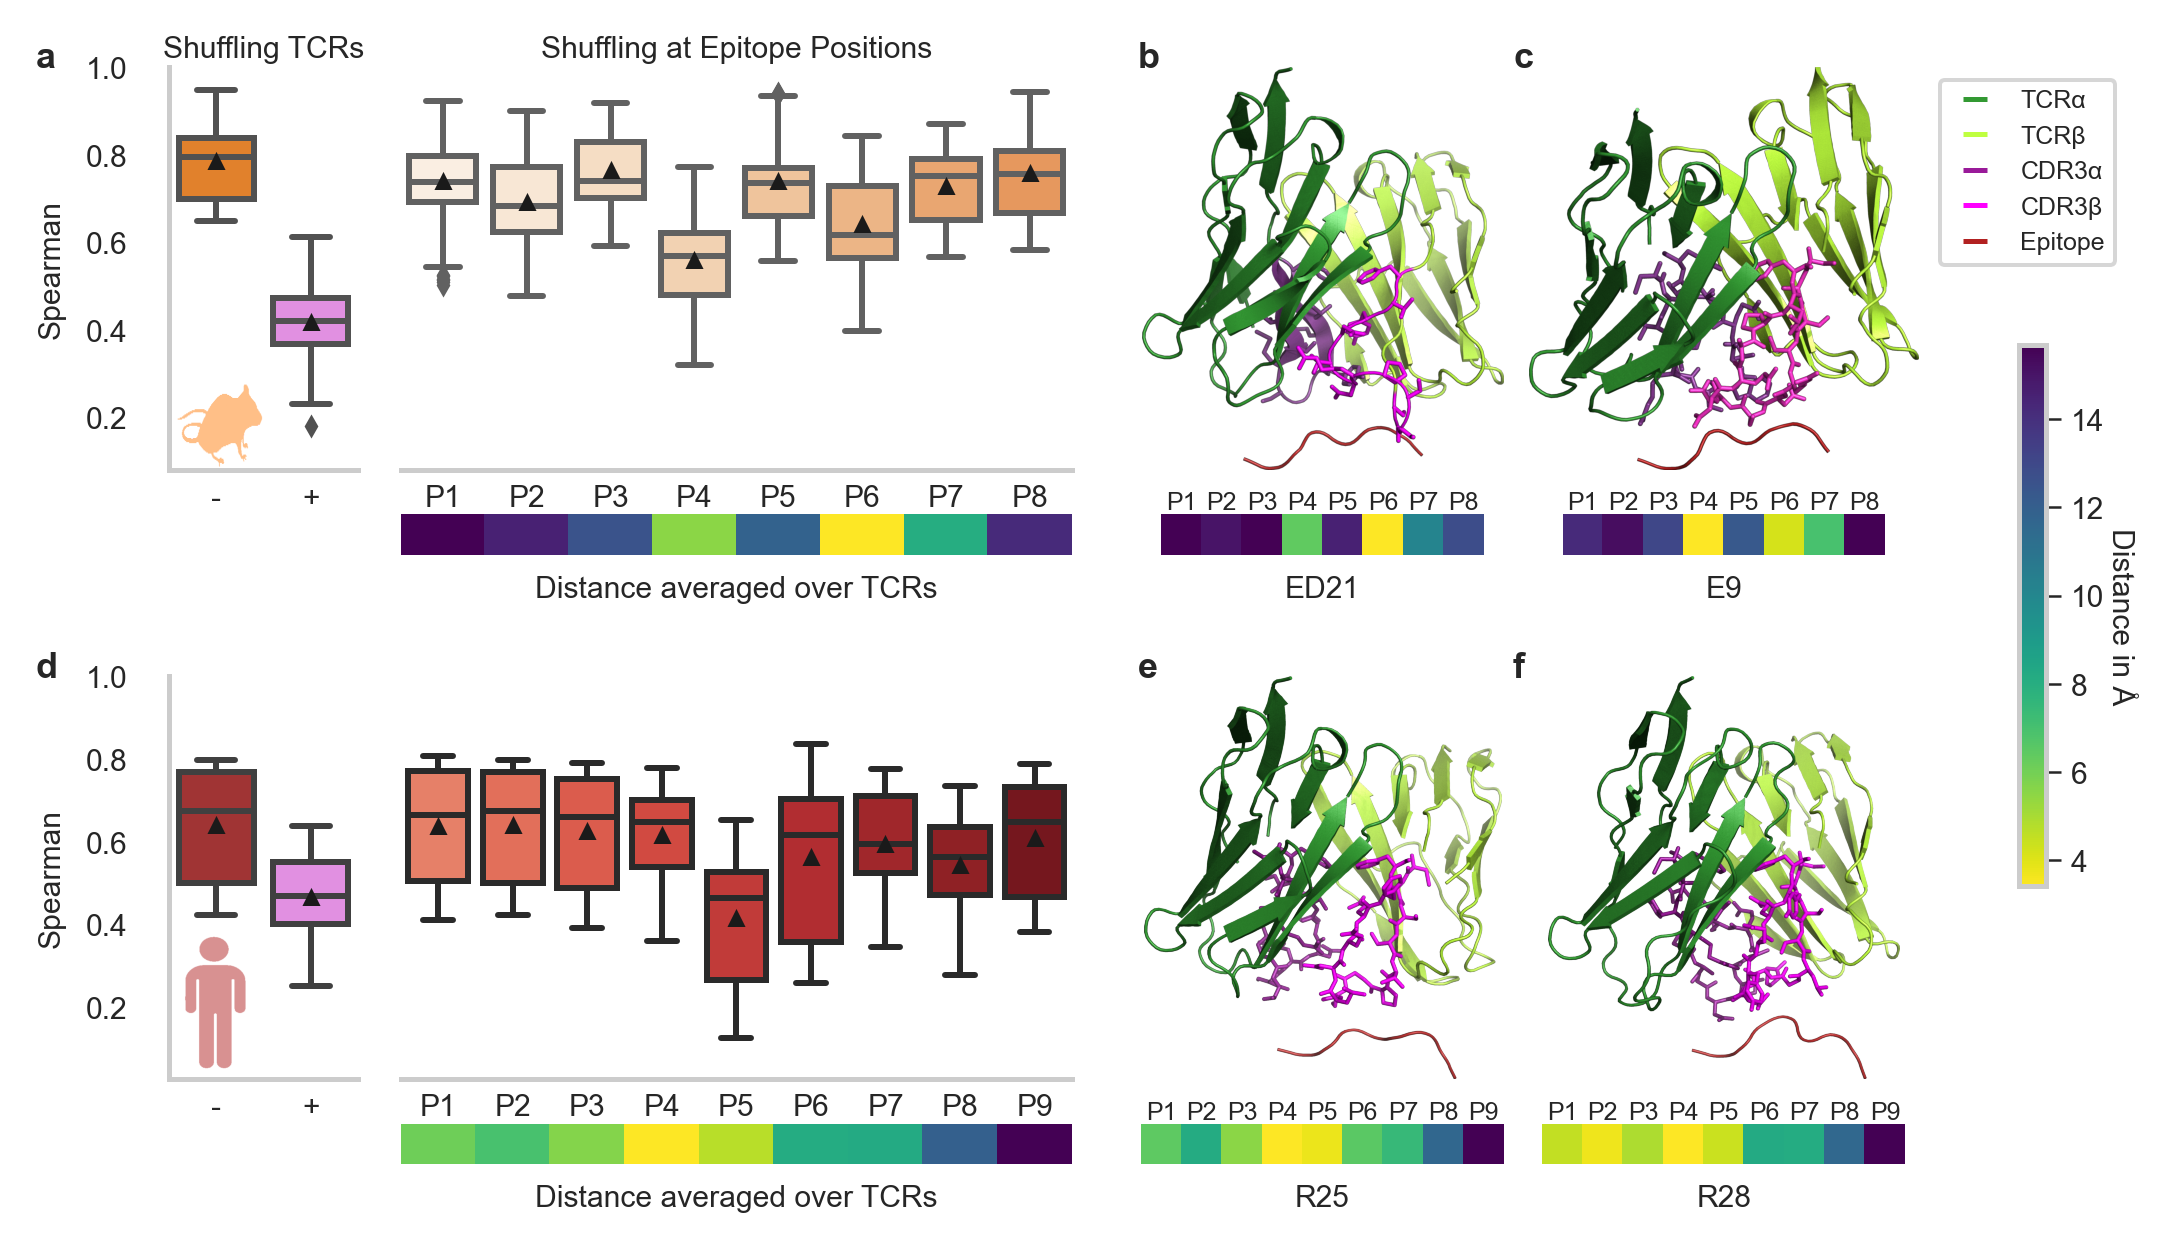

In [16]:
# base featureImportance  model1 model2 c
# base featureImportance  model1 model2 o
#      avg distances      dist 1 dist 2 l
#                                       
# base featureImportance  model1 model2 b       => same for human
# base featureImportance  model1 model2 a
#      avg distances      dist 1 dist 2 r


fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.6), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs1-15'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.11,
    #hspace=2/3,
)

gridspecs['gs1-14'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs1-15'][0],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    hspace=0.25
)

axes['cbar'] = fig.add_subplot(gridspecs['gs1-15'][1])
vmin, vmax = plot_colorbar(axes['cbar'], epitope='both', do_legend=True)

tcr_mice = ('Ed21', 'E9')
tcr_human = ('R25', 'R28')

for i, (dataset, tcrs) in enumerate([('mice', tcr_mice), ('human', tcr_human)]):
    gridspecs['gs1-7'] = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gridspecs['gs1-14'][i],
        nrows=1,
        ncols=2,
        width_ratios=[1, 1],
        wspace=0.0
    )
    gridspecs['gs1-3'] = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gridspecs['gs1-7'][0],
        nrows=2,
        ncols=2,
        height_ratios=[10, 1],
        width_ratios=[2.25, 8],
        wspace=0.1
    )
    gridspecs['gs4-7'] = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gridspecs['gs1-7'][1],
        nrows=2,
        ncols=2,
        height_ratios=[10, 1],
        width_ratios=[1, 1],
        wspace=-0.2
        #hspace=-0.15
    )    
    axes['ax_1'] = fig.add_subplot(gridspecs['gs1-3'][0])
    axes['ax_2'] = fig.add_subplot(gridspecs['gs1-3'][1])
    axes['ax_3'] = fig.add_subplot(gridspecs['gs1-3'][3])
    
    palette = palette_human if dataset=='human' else palette_educated
    palette_base = [palette_tcrs['Human'], color_cdr3] if dataset=='human' else [palette_tcrs['Educated'], color_cdr3]
    average_class = 'avg' if dataset=='mice' else 'Ravg'
    df_importance = df_importance_human if dataset=='human' else df_importance_mice

    if dataset == 'human':
        plot_icon(axes['ax_1'])
    else:
        plot_icon(axes['ax_1'], name='mouse', color=palette_tcrs['Educated'], scale=0.7, rscale=1.2)        
    
    plot_permutation_importance_base(df_importance, axes['ax_1'], palette_base, do_heading=dataset!='human')
    plot_permutation_importance_position(df_importance, axes['ax_2'], palette=palette, do_heading=dataset!='human')
    plot_3d_distances(axes['ax_3'], average_class, do_labels=False)
        
    axes['ax_4'] = fig.add_subplot(gridspecs['gs4-7'][0])
    axes['ax_5'] = fig.add_subplot(gridspecs['gs4-7'][1])
    axes['ax_6'] = fig.add_subplot(gridspecs['gs4-7'][2])
    axes['ax_7'] = fig.add_subplot(gridspecs['gs4-7'][3])
    
    plot_3d_structures(axes['ax_4'], tcrs[0])
    plot_3d_structures(axes['ax_5'], tcrs[1])
    plot_3d_distances(axes['ax_6'], tcrs[0])
    plot_3d_distances(axes['ax_7'], tcrs[1])
    
    fig.text(0.07, 0.88-i*0.42, abc[0+i*3], size='large', weight='bold')
    fig.text(0.525, 0.88-i*0.42, abc[1+i*3], size='large', weight='bold')
    fig.text(0.68, 0.88-i*0.42, abc[2+i*3], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_fig5_importance.pdf', dpi=DPI, bbox_inches='tight')

## Figure S5

<ipython-input-17-95e7809ebee6>:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


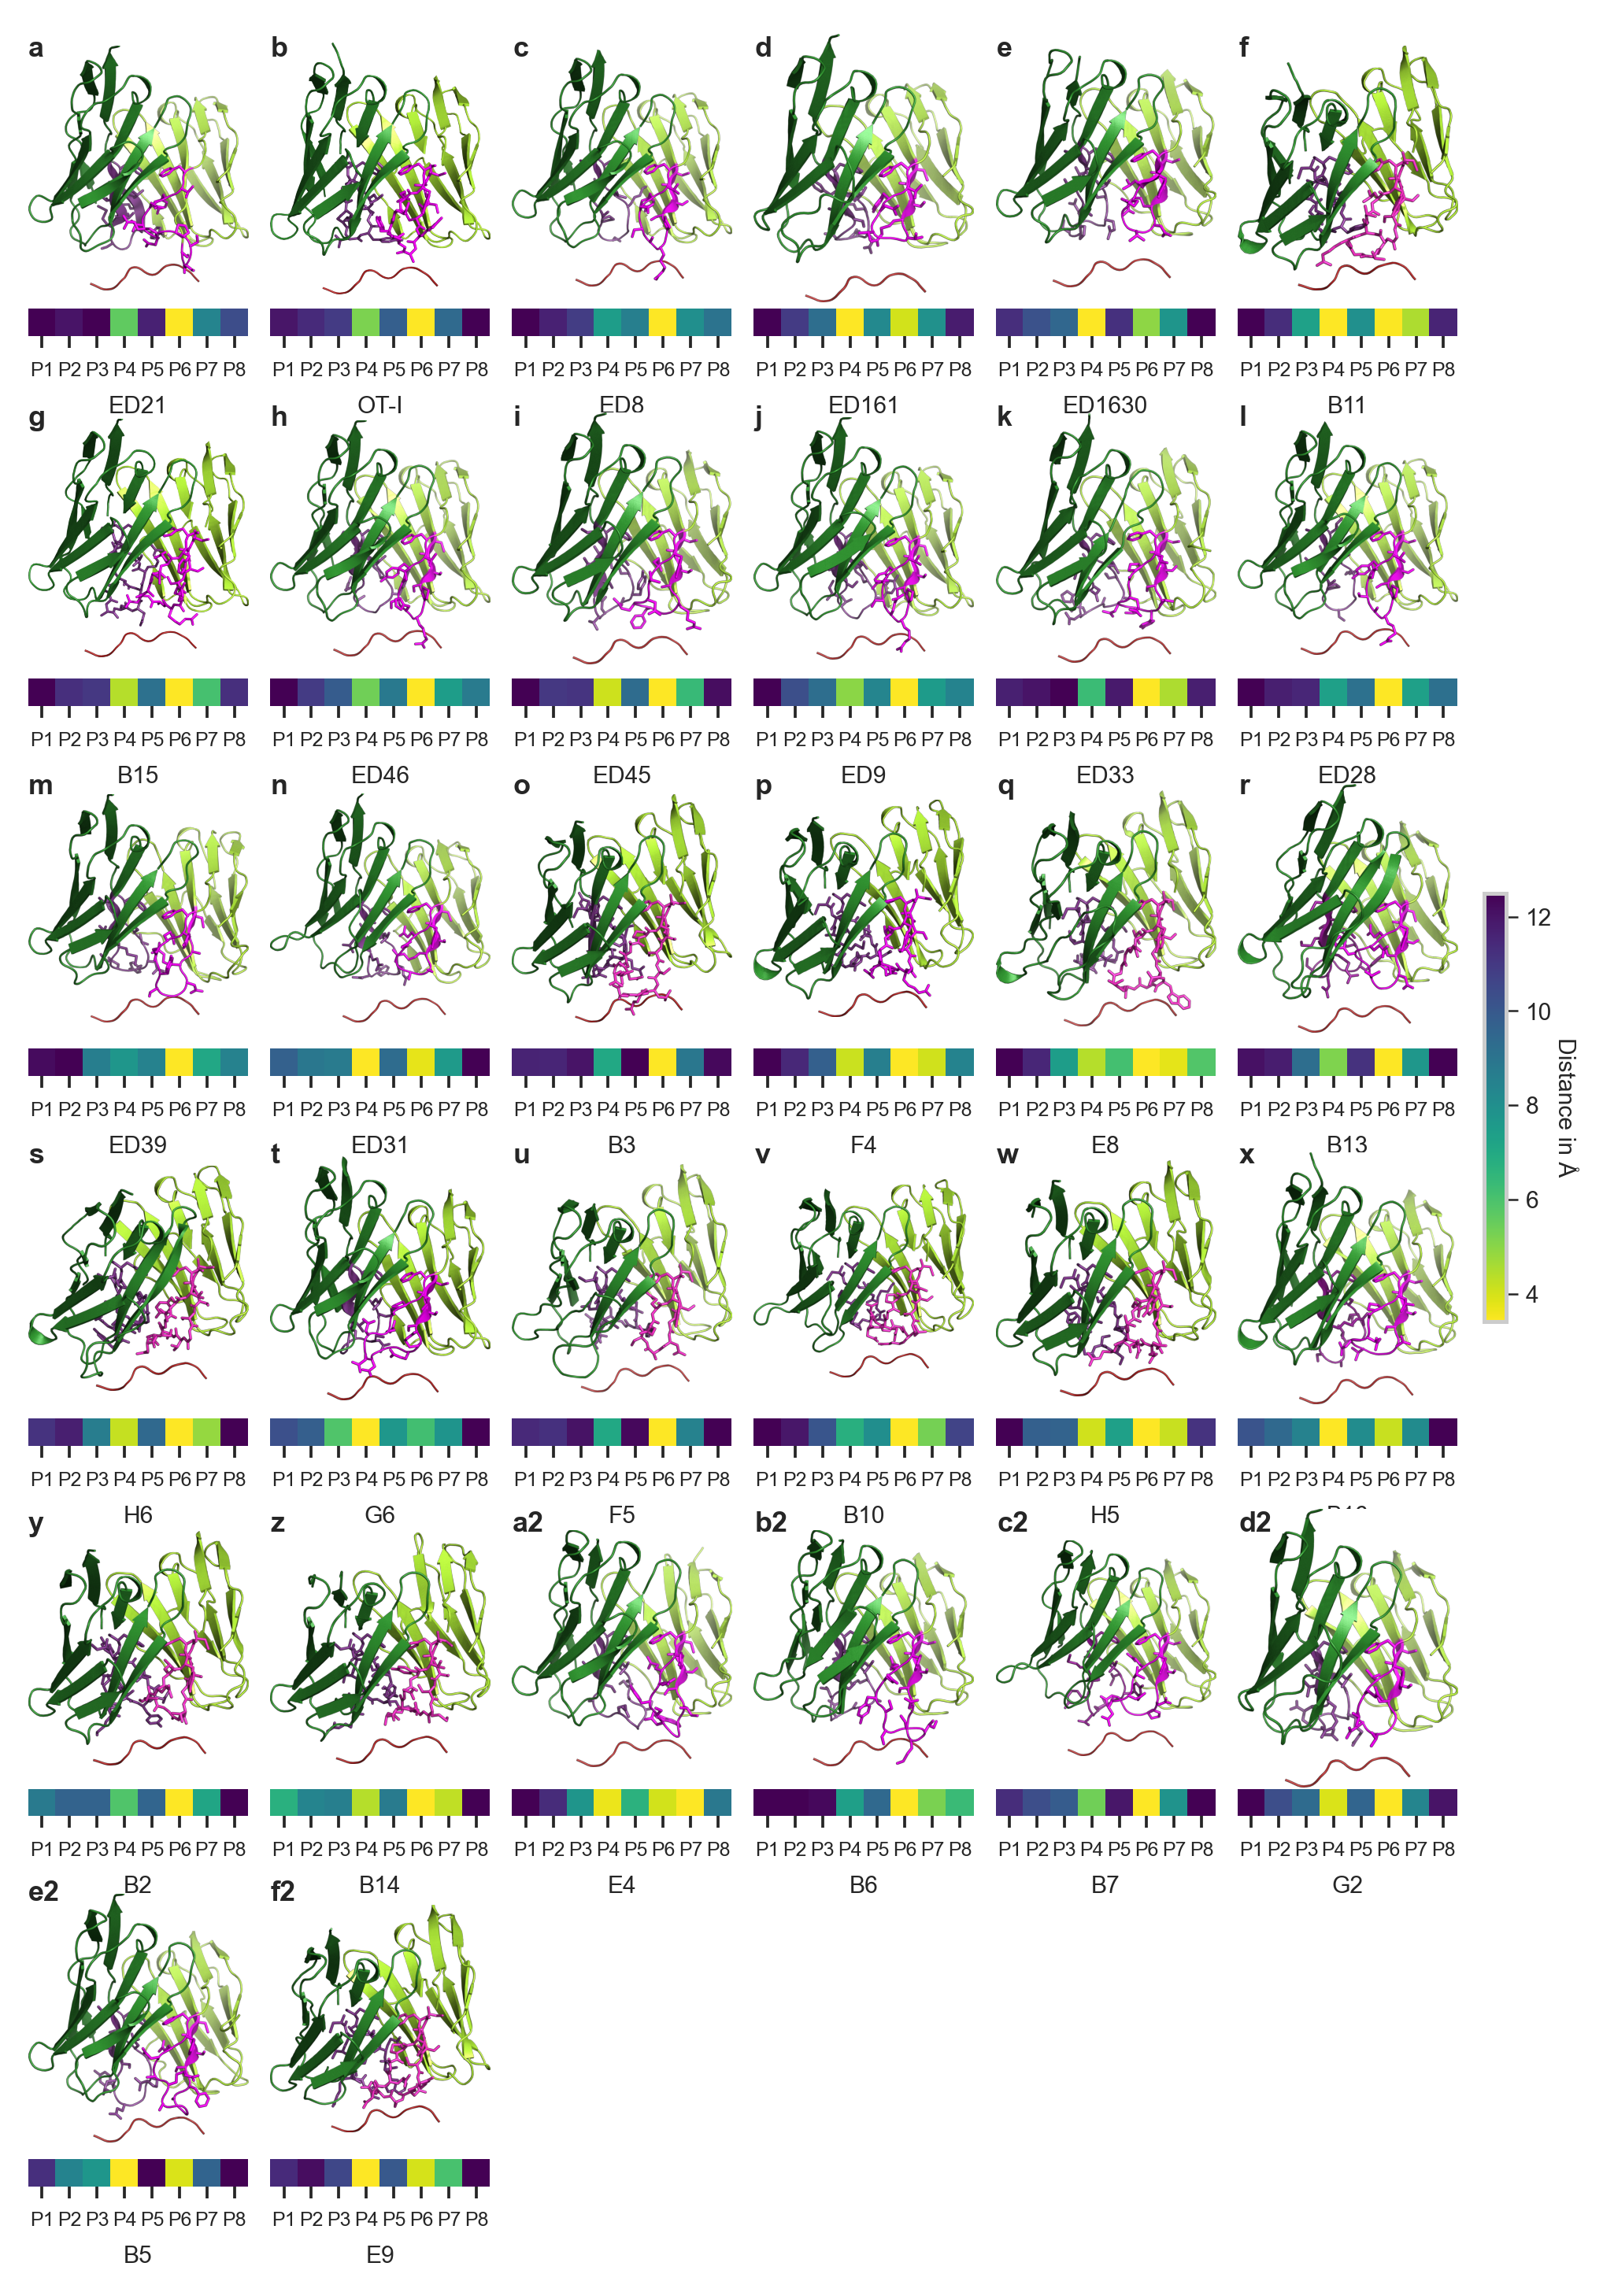

In [17]:
n_cols = 6
n_rows = (len(vis_names_mice)-1)//6 + 1

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25 * n_rows), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.12,
)

gs_vis = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=n_rows,
    ncols=n_cols,
    height_ratios=[1]*n_rows,
    width_ratios=[1] * n_cols,
    wspace=0.1,
    hspace=0.2
)

ax_cb = fig.add_subplot(gs[1])
plot_colorbar(ax_cb, 'SIINFEKL')

# Sorted by reactivity to SIINFEKL
vis_names_mice = [
    'Ed21', 'OT1', 'Ed8', 'Ed161', 'Ed1630', 'B11',
    'B15', 'Ed46', 'Ed45', 'Ed9', 'Ed33', 'Ed28', 'Ed39',
    'Ed31', 'B3', 'F4', 'E8', 'B13', 'H6', 'G6', 'F5', 'B10', 'H5', 'B16',
    'B2', 'B14', 'E4', 'B6', 'B7', 'G2', 'B5', 'E9']

for i, tcr in enumerate(vis_names_mice):
    row = i//n_cols
    col = i%n_cols
    gs_tcr = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_vis[i],
        nrows=2,
        ncols=1,
        height_ratios=[1, 0.1],
        hspace=-0.
    )
    ax_struc = fig.add_subplot(gs_tcr[0])
    plot_3d_structures(ax_struc, tcr)
    
    ax_dists = fig.add_subplot(gs_tcr[1])
    plot_3d_distances(ax_dists, tcr, legend_top=False)
    
    fig.text(0.125 + 0.127*col, 0.87-row*0.129, abc[i], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_s5_3d_model_mice.pdf', dpi=DPI, bbox_inches='tight')

## Figure S6

<ipython-input-18-6cd393b22bc8>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


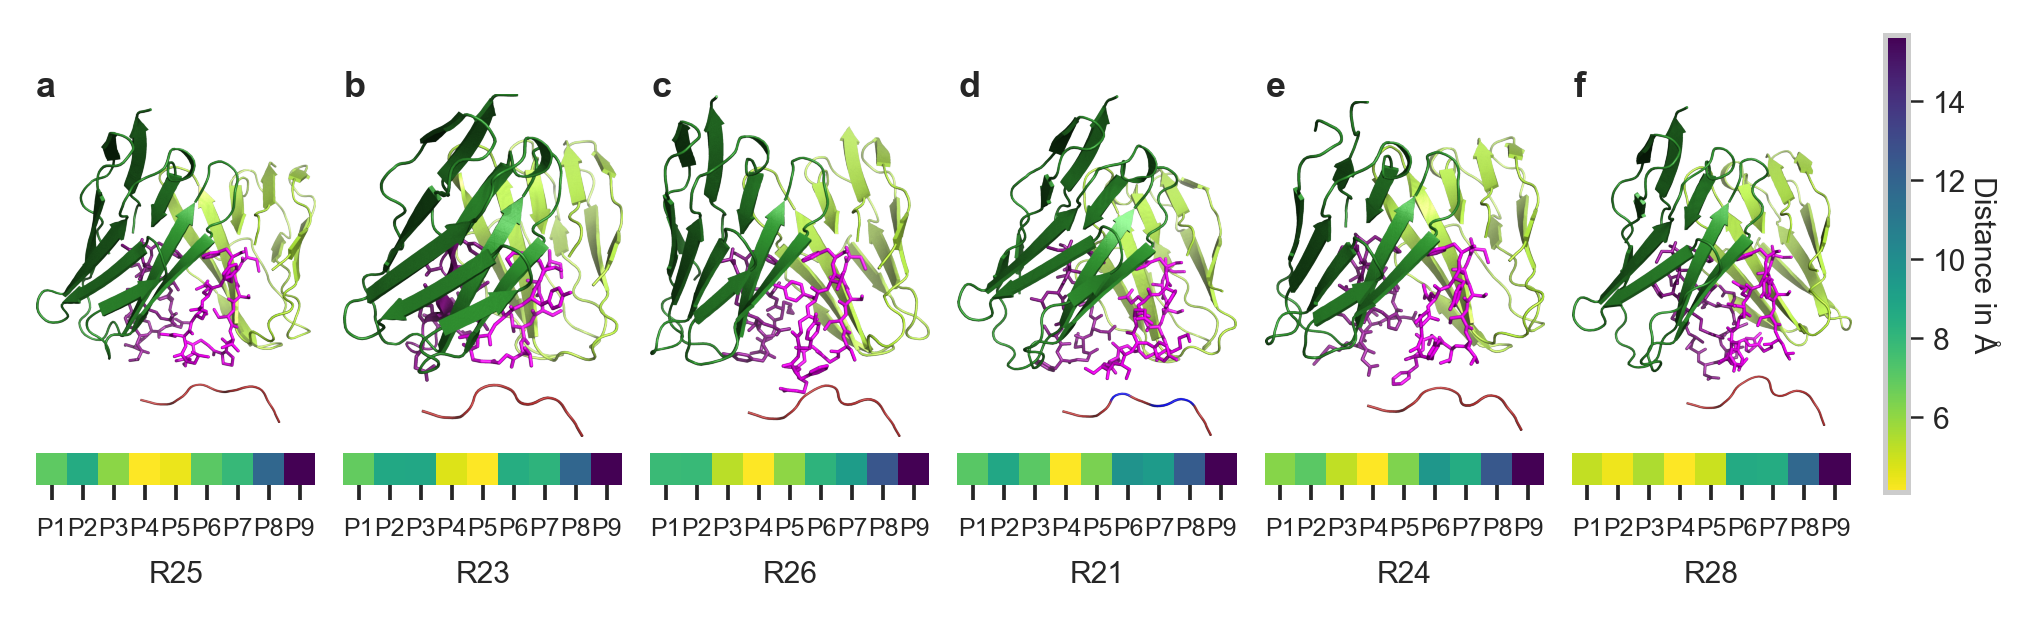

In [18]:
n_cols = 6
n_rows = (len(vis_names_human)-1)//6 + 1

# Sorted by Reactivity to VPSVWRSSL
vis_names_human = ['R25', 'R23', 'R26', 'R21', 'R24', 'R28']

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25 * n_rows), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.12,
)

gs_vis = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=n_rows,
    ncols=n_cols,
    height_ratios=[1]*n_rows,
    width_ratios=[1] * n_cols,
    wspace=0.1,
    hspace=0.2
)

ax_cb = fig.add_subplot(gs[1])
plot_colorbar(ax_cb, 'VPR')

for i, tcr in enumerate(vis_names_human):
    row = i//n_cols
    col = i%n_cols
    gs_tcr = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_vis[i],
        nrows=2,
        ncols=1,
        height_ratios=[1, 0.1],
        hspace=-0.2
    )
    ax_struc = fig.add_subplot(gs_tcr[0])
    plot_3d_structures(ax_struc, tcr)
    
    ax_dists = fig.add_subplot(gs_tcr[1])
    plot_3d_distances(ax_dists, tcr, legend_top=False)
    
    fig.text(0.125 + 0.127*col, 0.78-row*0.13, abc[i], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_s6_3d_model_human.pdf', dpi=DPI, bbox_inches='tight')

# Stats for paper

In [19]:
dists_mice_avg = np.vstack([dist for tcr, dist in dists_mice.items()]).mean(axis=0)
dists_mice_avg = pd.DataFrame(data=dists_mice_avg, index=[f'P{i+1}' for i in range(8)], columns=['distance'])

df_importance_mice_avg = df_importance_mice.groupby(['Permutation']).mean().sort_values('Spearman')
df_importance_mice_avg = pd.concat([df_importance_mice_avg, dists_mice_avg], axis=1)
df_importance_mice_avg

Spearman      base      diff       rel  distance
CDR3  0.416327  0.782187 -0.365860 -0.462863       NaN
P4    0.556520  0.782187 -0.225667 -0.289283  5.512574
P6    0.638984  0.782187 -0.143203 -0.183001  4.608275
P2    0.690250  0.782187 -0.091936 -0.119772  9.313581
P7    0.726645  0.782187 -0.055542 -0.068421  6.589564
P1    0.737050  0.782187 -0.045136 -0.055762  9.795427
P5    0.738390  0.782187 -0.043797 -0.055707  8.192974
P8    0.755449  0.782187 -0.026738 -0.035098  9.180278
P3    0.763425  0.782187 -0.018762 -0.021700  8.462829
-     0.782187  0.782187  0.000000  0.000000       NaN

In [20]:
print('Mice: correlation and p-value between Spearman and distance')
df_mice_pos = df_importance_mice_avg[df_importance_mice_avg.index.str.startswith('P')]
stats.pearsonr(df_mice_pos['Spearman'], df_mice_pos['distance'])

Mice: correlation and p-value between Spearman and distance


(0.7224114902701471, 0.04295942028998035)

In [21]:
dists_human_avg = np.vstack([dist for tcr, dist in dists_human.items()]).mean(axis=0)
dists_human_avg = pd.DataFrame(data=dists_human_avg, index=[f'P{i+1}' for i in range(9)], columns=['distance'])

df_importance_human_avg = df_importance_human.groupby(['Permutation']).mean().sort_values('Spearman')
df_importance_human_avg = pd.concat([df_importance_human_avg, dists_human_avg], axis=1)

# exclude positions 2 as we dont have any measurements there
df_importance_human_avg = df_importance_human_avg[df_importance_human_avg.index!='P2']
df_importance_human_avg

Spearman      base      diff       rel   distance
P5    0.412786  0.639038 -0.226252 -0.374530   5.641836
CDR3  0.464492  0.639038 -0.174546 -0.261925        NaN
P8    0.541923  0.639038 -0.097115 -0.148192  11.670817
P6    0.560551  0.639038 -0.078488 -0.139928   8.498233
P7    0.592822  0.639038 -0.046216 -0.066696   8.557034
P9    0.606159  0.639038 -0.032879 -0.054359  14.799690
P4    0.614163  0.639038 -0.024875 -0.025358   4.528241
P3    0.624202  0.639038 -0.014836 -0.023615   6.418907
P1    0.635405  0.639038 -0.003633 -0.004036   6.777392
-     0.639038  0.639038  0.000000  0.000000        NaN

In [22]:
print('Human: correlation and p-value between Spearman and distance')
df_human_pos = df_importance_human_avg[df_importance_human_avg.index.str.startswith('P')]
stats.pearsonr(df_human_pos['Spearman'], df_human_pos['distance'])

Human: correlation and p-value between Spearman and distance


(0.11204685975426512, 0.7916638805478258)

In [23]:
pd.DataFrame(data=np.vstack(dists_human.values()), columns=['P1'] + [f'P{i}' for i in range(2, 10)], index=dists_human.keys())

<ipython-input-23-84862165daf1>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pd.DataFrame(data=np.vstack(dists_human.values()), columns=['P1'] + [f'P{i}' for i in range(2, 10)], index=dists_human.keys())


P1        P2        P3        P4        P5        P6        P7  \
R21  7.038514  8.664587  6.984971  4.098284  6.362323  9.560147  9.240887   
R23  6.463537  8.022562  8.070881  4.631594  4.103581  7.834366  7.588848   
R24  6.389133  7.126117  5.561386  4.615252  6.509049  9.203836  8.363011   
R25  6.887116  8.195330  6.184569  4.579704  4.853171  6.965160  7.645446   
R26  7.864715  7.889381  5.364574  4.186455  6.114430  8.202807  9.348893   
R28  6.021338  5.309001  6.347065  5.058159  5.908464  9.223079  9.155120   

            P8         P9  
R21  12.133603  15.374036  
R23  10.703330  13.915141  
R24  11.699807  14.364870  
R25  10.790216  13.873730  
R26  12.546938  15.586619  
R28  12.151008  15.683747